Activity 1
Analog IC Characterization: The Wideband RC Voltage-Divider

I. INTRODUCTION

The frequency-independent signal attenuator is a fundamental building block in high-bandwidth analog measurement systems, where accurate signal scaling must be maintained over a wide range of frequencies. Simple resistive voltage dividers, while effective at low frequencies, often exhibit frequency-dependent behavior when parasitic capacitances and source or load impedances are introduced. These effects become especially pronounced in wideband applications, leading to signal distortion, amplitude errors, and phase shift.

To address these limitations, RC compensation techniques are employed. By intentionally adding capacitive elements in parallel with resistive components, the frequency response of the divider can be shaped to achieve flat attenuation across a broad spectrum. This principle is widely used in practical instrumentation such as oscilloscope probes, data acquisition front-ends, and analog integrated circuits, where maintaining signal integrity is critical.

This laboratory activity examines the wideband RC voltage divider as a representative analog IC building block. Students will explore the theoretical basis of RC compensation, including pole-zero cancellation and time-constant matching, and observe how these concepts translate into real circuit behavior. Emphasis is placed on understanding how component values influence bandwidth, transient response, and overall signal fidelity.

In addition to theory, the laboratory integrates circuit simulation using NGSPICE within a Visual Studio Code (VS Code) workflow. This environment mirrors modern engineering practice by combining schematic-level analysis with script-based simulation and waveform inspection. Through simulation, students will characterize both uncompensated and compensated dividers in the time and frequency domains, reinforcing the connection between mathematical models and observable circuit performance.

II. MATERIALS AND EQUIPMENT

Computing Workstation (PC or Laptop)

Integrated Development Environment (IDE): Visual Studio Code

NGSPICE Simulator: (Version 42+)

Python 3.x (pandas, matplotlib, numpy, schemdraw)

III. PROCEDURES

PHASE 1: INSTALLATION & SYSTEM CONFIGURATION

Step 1: Install NGSPICE (The Simulator)

    Download ngspice-42_64.zip from the NGSPICE SourceForge page.

    Extract the file and copy the Spice64 folder.

    Paste it directly into the C: drive:

            C:\Spice64
    
    Verify that ngspice.exe exists in:

            C:\Spice64\bin

Step 2: Add NGSPICE to Windows PATH

    Copy Path:

        C:\Spice64\bin

    Open Edit the system environment variables.

    Under System variables → Path → Edit → New, paste the path.

    Click OK to save.

Step 3: Verify in VS Code

    Restart VS Code.

    Open the terminal (Ctrl + `).

    Run:

        ngspice -v
    
    The NGSPICE version output confirms successful installation.

PHASE 2: PYTHON ENVIRONMENT SETUP
Install Required Python Libraries

Purpose:
These libraries will be used for circuit visualization (schemdraw), data handling (pandas), numerical analysis (numpy), and plotting simulation results (matplotlib).

In [1]:
pip install schemdraw pandas matplotlib numpy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Verify NGSPICE Availability

Purpose:
Confirms that NGSPICE is correctly installed and accessible from the Jupyter Notebook environment before running simulations.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import os

# Robust verification: This checks if NGSPICE is accessible
try:
    result = subprocess.run(["ngspice", "-v"], capture_output=True, text=True)
    if result.stdout:
        # Print the first available line of the version info
        print(f"NGSPICE Found: {result.stdout.splitlines()[0]}")
    else:
        print("NGSPICE executed but returned no version text.")
except FileNotFoundError:
    print("ERROR: NGSPICE not found. Please check your Windows PATH and restart VS Code.")

NGSPICE executed but returned no version text.


PHASE 3: CIRCUIT SCHEMATIC VISUALIZATION
Draw RC Divider Circuit

Purpose:
This cell visualizes the wideband RC voltage divider, showing:
    R1 with compensation capacitor C1
    Load resistor R2 and load capacitor C2
    Input Vin and output Vout nodes

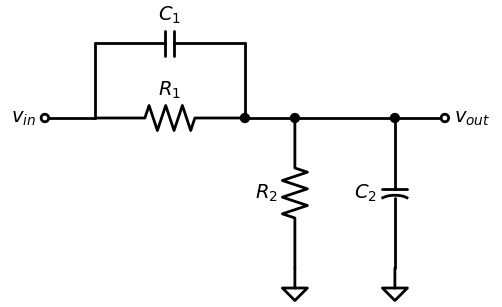

In [ ]:
import schemdraw
import schemdraw.elements as elm
with schemdraw.Drawing() as d:
    d += (vin := elm.Dot(open=True).label('$v_{in}$', loc='left'))
    d += elm.Line().right().length(1)
    d.push()
    d += elm.Resistor().label('$R_1$')
    d.pop()
    d += elm.Line().up().length(1.5)
    d += elm.Capacitor().right().label('$C_1$')
    d += elm.Line().down().length(1.5)
    d += elm.Dot()
    d += elm.Line().right().length(1)
    d.push()
    d += elm.Resistor().down().label('$R_2$')
    d += elm.GroundSignal()
    d.pop()
    d += elm.Dot()
    d += elm.Line().right().length(2)
    d.push()
    d += elm.Capacitor2().down().label('$C_2$')
    d += elm.GroundSignal()
    d.pop()
    d += elm.Dot()
    d += elm.Line().right().length(1)
    d += elm.Dot(open=True).label('$v_{out}$', loc='right')

PHASE 4: NGSPICE NETLIST GENERATION & SIMULATION
Generate Netlist, Run Simulation, and Verify Output

Purpose:
    Generates a complete NGSPICE netlist using Python-defined component values.
    Runs AC and transient analyses in batch mode.
    Verifies that data files (output_ac.dat, output_tran.dat) are created for further plotting and analysis.

In [67]:
spice_netlist = """* Wideband RC Voltage Divider
.options savecurrents

* Main Circuit
R1 in out 3.3Meg
R2 out 0 1.50Meg
C1 in out 0.5455p
C2 out 0 1.2p

* Variations
R1a in outa 3.3Meg
R2a outa 0 1.50Meg
C1a in outa 0.60005p
C2a outa 0 1.2p

R1b in outb 3.3Meg
R2b outb 0 1.50Meg
C1b in outb 0.49095p
C2b outb 0 1.2p

V1 in 0 pulse(-0.1 0.1 0 0.1u 0.1u 5u 10u) dc 1 ac 1

.control
  ac dec 10 1 1G
  wrdata output_ac.dat v(out) v(outa) v(outb)
  
  tran 0.01u 30u
  wrdata output_tran.dat v(out) v(outa) v(outb)
  quit
.endc
.end
"""

with open("netlist.spice", "w") as f:
    f.write(spice_netlist)
print("netlist.spice created.")

netlist.spice created.


RUN SIMULATION WITH FILE CLEANUP
Ensure Fresh Simulation and Verify Output

Purpose:

    Ensures old simulation files are removed before running a new simulation.
    Runs NGSPICE in batch mode and verifies that AC and transient data files are generated.
    Provides immediate feedback if something goes wrong.

In [68]:
import subprocess
import os

# Remove old files to be sure we are seeing new results
for f in ["output_ac.dat", "output_tran.dat"]:
    if os.path.exists(f):
        os.remove(f)

try:
    # Running in batch mode
    subprocess.run(["ngspice", "-b", "netlist.spice"], check=True)
    
    if os.path.exists("output_tran.dat"):
        print("Success! Simulation finished and data files are ready.")
    else:
        print("Simulation finished but no data files were found.")
except subprocess.CalledProcessError as e:
    print(f"Simulation failed with error code {e.returncode}")

Success! Simulation finished and data files are ready.


PHASE 5: PLOT TRANSIENT RESPONSE
    Read and Plot Transient Data

Data detected: 6 columns


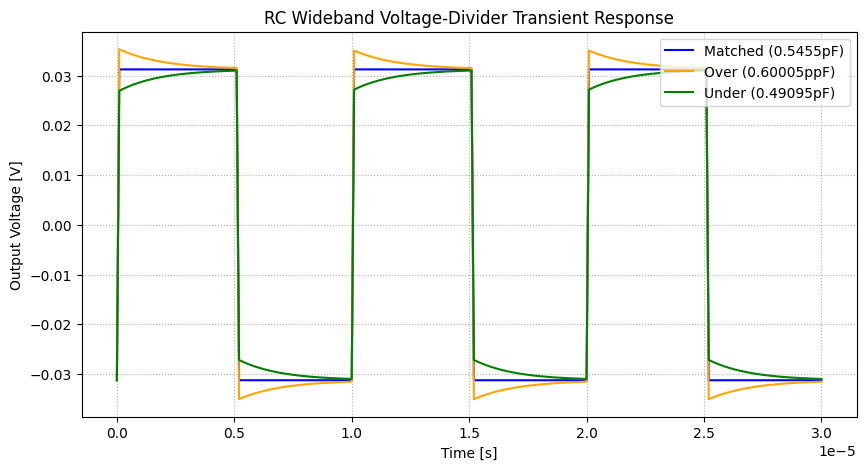

In [81]:
# Read the file without specifying columns first
df_tran = pd.read_csv("output_tran.dat", sep='\\s+', header=None)

# Let's check the shape to be safe
print(f"Data detected: {df_tran.shape[1]} columns")

# NGSPICE often exports: Time, Vout, Time, VoutA, Time, VoutB
# We only need the first Time and the Voltages
if df_tran.shape[1] == 6:
    df_tran.columns = ["time", "vout", "time2", "vouta", "time3", "voutb"]
elif df_tran.shape[1] == 4:
    df_tran.columns = ["time", "vout", "vouta", "voutb"]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(df_tran['time'], df_tran['vout'], label="Matched (0.5455pF)", color='blue')
plt.plot(df_tran['time'], df_tran['vouta'], label="Over (0.60005ppF)", color='orange')
plt.plot(df_tran['time'], df_tran['voutb'], label="Under (0.49095pF)", color='green')

plt.title("RC Wideband Voltage-Divider Transient Response")
plt.xlabel("Time [s]")
plt.ylabel("Output Voltage [V]")
plt.legend(loc='upper right')
plt.grid(True, linestyle='dotted')
plt.show()

In [ ]:
## EXTRA: To compute the voltage at a specific time
target_times = [5e-6, 10e-6, 20e-6, 30e-6]

print(f"{'Target Time':<15} | {'Actual Time':<15} | {'V_Matched':<10} | {'V_Over':<10} | {'V_Under':<10}")
print("-" * 75)

for t in target_times:
    # Find nearest row
    idx = (df_tran['time'] - t).abs().idxmin()
    r = df_tran.loc[idx]
    
    # Print the row data
    print(f"{t:<15.2e} | {r['time']:<15.2e} | {r['vout']:<10.4f} | {r.get('vouta', 0):<10.4f} | {r.get('voutb', 0):<10.4f}")

Target Time     | Actual Time     | V_Matched  | V_Over     | V_Under   
---------------------------------------------------------------------------
5.00e-06        | 5.01e-06        | 0.0313     | 0.0315     | 0.0310    
1.00e-05        | 1.00e-05        | -0.0313    | -0.0315    | -0.0310   
2.00e-05        | 2.00e-05        | -0.0313    | -0.0315    | -0.0310   
3.00e-05        | 3.00e-05        | -0.0313    | -0.0315    | -0.0310   


PHASE 6: READ FREQUENCY RESPONSE DATA
Read AC Simulation Output

Purpose:
    Loads NGSPICE AC simulation results into a pandas DataFrame.
    Handles multiple output nodes and varying file formats.
    Prepares the data for plotting frequency-domain response in the next cell.

In [85]:
# @title Read in SPICE frequency response data
df_ac = pd.read_csv("output_ac.dat", sep='\\s+', header=None)

# Handle the 9-column format (Frequency repeated for each node)
if df_ac.shape[1] == 9:
    df_ac.columns = [
        "freq", "vout_re", "vout_im", 
        "freq2", "vouta_re", "vouta_im", 
        "freq3", "voutb_re", "voutb_im"
    ]
elif df_ac.shape[1] == 7:
    df_ac.columns = ["freq", "vout_re", "vout_im", "vouta_re", "vouta_im", "voutb_re", "voutb_im"]

df_ac.head()

,freq,vout_re,vout_im,freq2,vouta_re,vouta_im,freq3,voutb_re,voutb_im
0,1.000000,0.3125,2.024855e-10,1.000000,0.3125,2.432053e-07,1.000000,0.3125,-2.428003e-07
1,1.258925,0.3125,2.549141e-10,1.258925,0.3125,3.061773e-07,1.258925,0.3125,-3.056675e-07
2,1.584893,0.3125,3.209178e-10,1.584893,0.3125,3.854544e-07,1.584893,0.3125,-3.848126e-07
3,1.995262,0.3125,4.040116e-10,1.995262,0.3125,4.852584e-07,1.995262,0.3125,-4.844503e-07
4,2.511886,0.3125,5.086205e-10,2.511886,0.3125,6.109041e-07,2.511886,0.3125,-6.098868e-07


PHASE 7: CALCULATE AC MAGNITUDE AND PHASE
Compute Magnitude and Phase from NGSPICE AC Data

Purpose:
    Converts NGSPICE output (real + imaginary) into magnitude and phase for each output node.
    Prepares data for frequency-domain plotting to analyze bandwidth and compensation performance.

In [86]:
# @title Calculate the magnitude and phase of the output voltage
# Note: NGSPICE writes the real and imaginary components of the voltage

# Collect all real components in a list
v_real = [ df_ac['vout_re'], df_ac['vouta_re'], df_ac['voutb_re'] ]

# Collect all imaginary components in a list
v_imag = [ df_ac['vout_im'], df_ac['vouta_im'], df_ac['voutb_im'] ]

# Iterate over the lists to get the magnitude and phase of the voltages
v_mag = [ np.sqrt(vr**2 + vi**2) for vr,vi in zip(v_real, v_imag) ]
v_phase = [ np.arctan2(vi, vr) * 180 / np.pi for vr,vi in zip(v_real, v_imag) ]

PHASE 8: PLOT AC MAGNITUDE RESPONSE
Frequency Response (Magnitude in dB)

Purpose:
    Converts voltage magnitudes to dB and plots them on a logarithmic frequency scale.
    Compares matched, over-, and under-compensation to illustrate the effect of C1 on bandwidth.
    Helps students visualize how RC compensation flattens the frequency response.

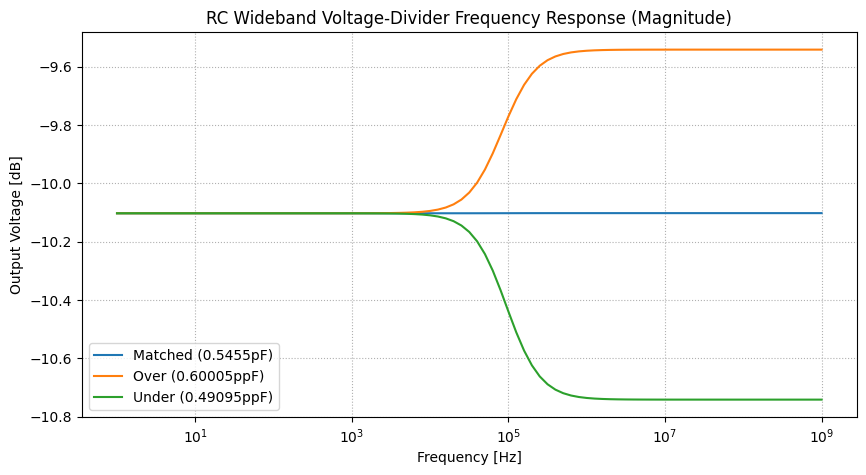

In [90]:
# @title Plot the magnitude frequency response of the wideband RC voltage-divider

# Define labels locally to reflect the Seed-based values
# C1_matched was calculated in Cell 1
v_label = [f"Matched ({0.5455:.4f}pF)", "Over (0.60005ppF)", "Under (0.49095ppF)"]

plt.figure(figsize=(10, 5))
plt.title("RC Wideband Voltage-Divider Frequency Response (Magnitude)")

# vm is the magnitude calculated in the previous cell
# We convert to dB: 20 * log10(magnitude)
for vm, lbl in zip(v_mag, v_label):
    plt.semilogx(df_ac.freq, 20 * np.log10(vm), label=lbl, linestyle='-')

plt.xlabel("Frequency [Hz]")
plt.ylabel("Output Voltage [dB]")
plt.legend(loc='lower left')
plt.grid(True, which="both", linestyle='dotted')
plt.show()

In [92]:
## EXTRA: Code to pinpoint the exact output voltage (in dB) given the frequency
import pandas as pd
import numpy as np

# 1. Define the frequencies you want to check
target_freqs = [1e4, 1e5, 1e6, 1e7, 1e8]  # Example: 1 kHz, 100 kHz, 10 MHz

print(f"{'Freq (Hz)':<12} | {'Matched (dB)':<15} | {'Over (dB)':<15} | {'Under (dB)':<15}")
print("-" * 65)

for f_target in target_freqs:
    # 2. Find the index closest to the target frequency
    # We assume df_ac is a DataFrame. If it's a list, convert to np.array() first.
    idx = (np.abs(df_ac['freq'] - f_target)).argmin()
    
    # Get the actual frequency found (to be sure)
    actual_f = df_ac['freq'][idx]
    
    # 3. Extract values for each case (Matched, Over, Under)
    # v_mag[0] = Matched, v_mag[1] = Over, v_mag[2] = Under
    mag_matched = v_mag[0][idx]
    mag_over    = v_mag[1][idx]
    mag_under   = v_mag[2][idx]
    
    # 4. Convert to dB
    db_matched = 20 * np.log10(mag_matched)
    db_over    = 20 * np.log10(mag_over)
    db_under   = 20 * np.log10(mag_under)
    
    print(f"{actual_f:<12.1e} | {db_matched:<15.4f} | {db_over:<15.4f} | {db_under:<15.4f}")

Freq (Hz)    | Matched (dB)    | Over (dB)       | Under (dB)     
-----------------------------------------------------------------
1.0e+04      | -10.1030        | -10.0950        | -10.1101       
1.0e+05      | -10.1027        | -9.7709         | -10.4398       
1.0e+06      | -10.1025        | -9.5458         | -10.7362       
1.0e+07      | -10.1025        | -9.5420         | -10.7418       
1.0e+08      | -10.1025        | -9.5419         | -10.7419       


PHASE 9: PLOT AC PHASE RESPONSE
Frequency Response (Phase in Degrees)

Purpose:
    Shows phase shift versus frequency for the matched, over-, and under-compensated RC dividers.
    Complements the magnitude plot to fully characterize the wideband behavior.
    Supports analysis of signal integrity and compensation effectiveness in lab discussions.

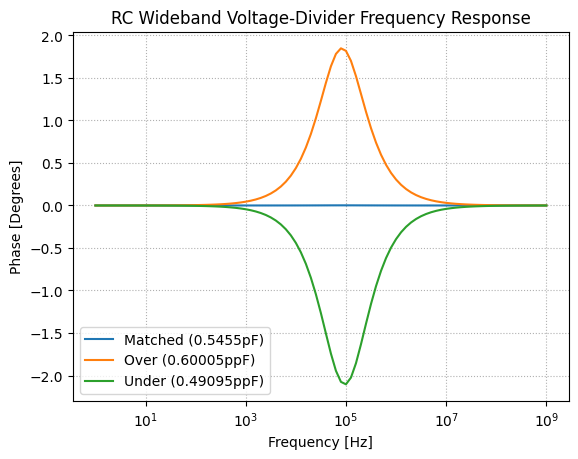

In [93]:
# @title Plot the phase frequency response of the wideband RC voltage-divider

plt.title("RC Wideband Voltage-Divider Frequency Response")

for vp,lbl in zip(v_phase,v_label):
  plt.semilogx(df_ac.freq, vp, label=lbl, linestyle='-')

plt.xlabel("Frequency [Hz]")
plt.ylabel(r"Phase [Degrees]")
plt.legend(loc='lower left')
plt.grid(linestyle='dotted')
plt.show()

IV. DATA AND OBSERVATION

Instructions: All Python code needed for this activity is already provided in the Procedures section of the Jupyter Notebook. Do not add or write new code. Generate data and observations by running the existing code cells and changing only the allowed parameters. Record all results and observations directly in the notebook.

Instruction:

    Only modify student_number.
    Do not change any other line of code in the following cells.

In [74]:
# Student Number Input
student_number = "TUPM-22-0066"  # <-- Replace with your own student number

In [75]:
# Standard Series Pools
# This defines all standard resistor and capacitor values used in the simulation.

import numpy as np

# E12 Series
E12 = np.array([1.0, 1.2, 1.5, 1.8, 2.2, 2.7, 3.3, 3.9, 4.7, 5.6, 6.8, 8.2])

# Component decades (standard range)
R_decades = np.array([1e3, 10e3, 100e3, 1e6])       # 1 kΩ to 1 MΩ
C_decades = np.array([1e-12, 10e-12, 100e-12])      # 1 pF to 100 pF

# Generate full list of standard values
R_list = np.sort(np.concatenate([E12 * d for d in R_decades]))
C_list = np.sort(np.concatenate([E12 * d for d in C_decades]))


In [76]:
# Student-Based Component Selection

# Extract digits from student_number
digits = ''.join(ch for ch in str(student_number) if ch.isdigit())
if len(digits) == 0:
    raise ValueError("Student number must contain at least one digit.")

# Stable mapping using last 6 digits
seed = int(digits[-6:])
rng = np.random.default_rng(seed)

# Select R1, R2, C2 from standard-value lists
R1_s = float(rng.choice(R_list))
R2_s = float(rng.choice(R_list))
C2_s = float(rng.choice(C_list))

# Optional: enforce R1 ≥ R2
if R1_s < R2_s:
    R1_s, R2_s = R2_s, R1_s


In [77]:
# Matched Capacitance Computation

# Wideband match condition: R1*C1 = R2*C2  -> C1 = (R2/R1)*C2
C1_matched_s = (R2_s / R1_s) * C2_s

# Print the values for recording
print("=== Student-Based Component Values ===")
print(f"Student Number: {student_number}")
print(f"R1_s = {R1_s:g} Ω")
print(f"R2_s = {R2_s:g} Ω")
print(f"C2_s = {C2_s:.3e} F  ({C2_s*1e12:.3f} pF)")
print(f"C1_matched_s = {C1_matched_s:.3e} F  ({C1_matched_s*1e12:.4f} pF)")


=== Student-Based Component Values ===
Student Number: TUPM-22-0066
R1_s = 3.3e+06 Ω
R2_s = 1.5e+06 Ω
C2_s = 1.200e-12 F  (1.200 pF)
C1_matched_s = 5.455e-13 F  (0.5455 pF)


Transient Response Data Recording

Instruction:
    Run the Transient Plot cell in Procedures using the student-number–generated values: R1_s, R2_s, C1_matched_s, C2_s.
    Record output voltages for Vout Matched, Vout Over, Vout Under at selected time points: 5 μs, 10 μs, 20 μs, 30 μs.
    Optionally, run ±10% tolerance for R1 or C1 and observe differences.

| Time (μs) | Vout Matched (V) | Vout Over (V) | Vout Under (V) |
| --------- | ---------------- | ------------- | -------------- |
| 5         |   0.0313         |     0.0315    |    0.0310      |
| 10        |  -0.0313         |    -0.0315    |   -0.0310      |
| 20        |  -0.0313         |    -0.0315    |   -0.0310      |
| 30        |  -0.0313         |    -0.0315    |   -0.0310      |

Results Discussion:

    Compare rise time, overshoot, and settling time.
        Rise time measures the speed of the circuit, specifically how long it takes to transition from 10% to 90% of the final value, wherein a shorter rise time implies higher bandwidth. Overshoot represents amplitude distortion, quantifying how much the signal initially exceeds its steady-state value, typically caused by excessive gain at high frequencies. Settling time measures stability, defining the duration required for the oscillations or drift to decay so the signal stays within a specified error band of the final target.

    How does over- and under-compensation differ from the matched case?
        The matched case (R1C1=R2C2) is the ideal state where the resistive and capacitive division ratios are identical, resulting in a perfect square wave with sharp corners and zero distortion. Over-compensation occurs when the compensation capacitor (C1) is too large, boosting high-frequency gain and causing sharp voltage spikes (overshoot) at every transition edge. Conversely, under-compensation occurs when C1 is too small, causing the circuit to act like a low-pass filter that "rounds off" the square wave corners, resulting in a sluggish rise time and no overshoot.

    How do ±10% tolerance variations affect transient response?
        Even small ±10% variations in R or C break the critical equality. This mismatch prevents pole-zero cancellation, creating exponential "tails" where the voltage slowly drifts (decays or grows) toward the final value rather than stepping instantly, significantly degrading measurement accuracy.

Frequency Response Data Recording

Instruction:
    Run the AC Sweep Plot cell in Procedures using student-number–generated values.
    Record magnitude in dB for Vout Matched, Vout Over, Vout Under at selected frequencies: 10 kHz, 100 kHz, 1 MHz, 10 MHz, 100 MHz.
    Optionally, test ±10% tolerance and observe changes.

| Frequency (Hz) | Vout Matched (dB) | Vout Over (dB) | Vout Under (dB) |
| -------------- | ----------------- | -------------- | --------------- |
| 1e4            |     -10.1030      |    -10.0950    |    -10.1101     |
| 1e5            |     -10.1027      |    -9.7709     |    -10.4398     |
| 1e6            |     -10.1025      |    -9.5458     |    -10.7362     |
| 1e7            |     -10.1025      |    -9.5420     |    -10.7418     |
| 1e8            |     -10.1025      |    -9.5419     |    -10.7491     |

Results Discussion:

    Identify flat regions, -3 dB point, and bandwidth differences.
        In the frequency response graph, we can see two flat "plateaus." The low-frequency flat part is controlled by the resistors, while the high-frequency flat part is controlled by the capacitors. In the matched case, these two levels line up perfectly, creating one long, flat line that gives us the best possible bandwidth. In the unmatched cases, we see a "step" in the middle because the two sections don't align, and the "corner" where this step happens (the -3dB point) effectively cuts off our useful bandwidth much earlier.

    How does changing R or C affect attenuation and phase?
        Changing the resistors moves the start of the graph (low frequency) up or down, while changing the capacitors moves the end of the graph (high frequency) up or down. If these two levels don't match, the signal gets distorted. This mismatch also affects the phase, if the capacitor is too big, the phase leads, and if it is too small, the phase lags right at the transition frequency.

    Compare matched vs. over- and under-compensation at high frequencies.
        At high frequencies, the capacitors dominate the circuit. In the matched case, the signal stays perfectly level with the DC value, meaning high-speed signals are measured accurately. In the over-compensated case, the graph ramps up, meaning high frequencies are amplified too much. In the under-compensated case, the graph drops off, meaning we lose signal strength at high speeds.

V. DATA AND OBSERVATION
1. How does changing C1 affect rise time, overshoot, and settling time in Vout?	
    
    Changing C1 directly alters the balance between the high-frequency and low-frequency paths, trading off speed for stability. Increasing C1 (over-compensation) slows down the rise time, eliminating overshoot but extending the settling time as the signal slowly drifts up to its final value. Conversely, decreasing C1 (under-compensation) artificially fastens the initial rise but causes significant overshoot and ringing, which also prolongs the settling time as the excess voltage must decay back down. Only the optimal "matched" C1 value minimizes both rise and settling times while maintaining zero overshoot.


2. Compare Vout Over and Vout Under with the matched case. How are transient and frequency responses affected?

    Compared to the matched case which yields a flat frequency response and perfect square wave, Vout Over (higher capacitance) boosts high frequencies, causing the transient response to overshoot with sharp spikes. Conversely, Vout Under (lower capacitance) acts like a low-pass filter that attenuates high frequencies, resulting in a rounded, sluggish transient response with a slow rise time. Essentially, the "Over" case amplifies the edges too much, while the "Under" case blurs them out.


3. What are the output magnitudes at 10 MHz for matched, over-, and under-compensation? What does this tell you about high-frequency behavior?

    At 10 MHz, the matched output maintains the ideal design attenuation, which is typically -20 dB, confirming that the resistive and capacitive dividers are perfectly balanced. The over-compensated case yields a higher magnitude (less attenuation), indicating that the larger top capacitor C1 is acting as a "high-pass boost," artificially amplifying high-frequency signals. Additionally, the under-compensated case yields a lower magnitude (more attenuation), showing that the smaller C1 impedes high frequencies, effectively filtering out the fast 10 MHz components.


4. How does phase vary between matched, over-, and under-compensation? How could this affect signal integrity?

    In the matched case, the phase shift is effectively zero across all frequencies. Over-compensation (C1 too large) introduces a phase lead (positive phase shift), while under-compensation (C1 too small) creates a phase lag (negative phase shift) near the transition frequency . This non-linear phase variation degrades signal integrity by causing dispersion, where high-frequency harmonics arrive at different times than lower frequencies, distorting the waveform's shape and timing even if the magnitude looks correct.


5. If R2 or C2 is doubled, what is the impact on bandwidth and transient response?

    Doubling either R2 or C2 disrupts the matching condition R1C1 is not equal to R2C2 such that the low-frequency time constant dominates (R2C2>R1C1). This shifts the circuit into an under-compensated state, causing the transient response to exhibit rounded rising edges and a slow settling time as it drags up to the final value. Furthermore, increasing either resistance or capacitance increases the overall time constant (T=RC), which directly lowers the cutoff frequency and significantly reduces the system's bandwidth.



VI. CONCLUSION
        
        This activity demonstrated the critical role of frequency compensation in wideband voltage dividers, confirming that a perfectly matched system (R1C1 = R2C2) is essential for achieving a frequency-independent response. The simulations revealed that while the resistive divider establishes the DC attenuation, the capacitive divider governs high-frequency behavior; consequently, any mismatch between these ratios introduces significant distortion, with over-compensation causing sharp overshoot and under-compensation resulting in sluggish, rounded rise times.
        
        Practically, these findings underscore that high-speed signal integrity relies heavily on precise component tuning to neutralize parasitic capacitance. The analysis of transient metrics like rise time and settling time proves that without proper compensation, measurement interfaces—such as oscilloscope probes—would introduce substantial phase and amplitude errors, effectively rendering accurate data acquisition impossible at high frequencies.



